# AL-FEP Real Protein Testing: 7JVR (SARS-CoV-2 Main Protease)

This notebook demonstrates the AL-FEP pipeline using the real SARS-CoV-2 Main Protease (7JVR) structure.

## Overview
- **Target**: 7JVR (SARS-CoV-2 Main Protease)
- **Resolution**: 1.25 Å
- **Binding Site**: [10.5, -7.2, 15.8]
- **Test Oracles**: ML-FEP, Docking (Mock), FEP (Mock)
- **Active Learning**: Uncertainty sampling with real molecular data

In [1]:
# Import required libraries
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Add src to path
sys.path.append('../src')

# AL-FEP imports
from al_fep import (
    MLFEPOracle, DockingOracle, FEPOracle,
    ActiveLearningPipeline,
    MolecularDataset, MolecularFeaturizer,
    setup_logging, load_config
)

# RDKit imports
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw
from rdkit.Chem.Draw import IPythonConsole

# Setup logging
setup_logging(level="INFO")

print("✓ All imports successful!")

/home/aoxu/miniconda3/envs/molpal/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-17 11:55:08,834 - al_fep.utils.logging_utils - INFO - Logging configured at level INFO


✓ All imports successful!


## 1. Load 7JVR Configuration and Validate Structure

In [2]:
# Load 7JVR configuration
config_dir = Path('../config')
config = load_config(
    config_dir / 'targets' / '7jvr.yaml',
    config_dir / 'default.yaml'
)

print("7JVR Target Configuration:")
print(f"- PDB ID: {config['target_info']['pdb_id']}")
print(f"- Name: {config['target_info']['name']}")
print(f"- Resolution: {config['target_info']['resolution']} Å")
print(f"- Binding Site Center: {config['binding_site']['center']}")
print(f"- Search Box Size: {config['binding_site']['size']}")

# Check if PDB file exists
pdb_file = Path('../data/targets/7jvr/7JVR.pdb')
print(f"\nPDB File Status: {'✓ Found' if pdb_file.exists() else '✗ Missing'}")
if pdb_file.exists():
    print(f"File size: {pdb_file.stat().st_size / 1024:.1f} KB")

2025-06-17 11:55:08,841 - al_fep.utils.config - INFO - Loaded default config from ../config/default.yaml
2025-06-17 11:55:08,843 - al_fep.utils.config - INFO - Loaded config from ../config/targets/7jvr.yaml
2025-06-17 11:55:08,843 - al_fep.utils.config - INFO - Loaded config from ../config/targets/7jvr.yaml


7JVR Target Configuration:
- PDB ID: 7JVR
- Name: SARS-CoV-2 Main Protease
- Resolution: 1.25 Å
- Binding Site Center: [10.5, -7.2, 15.8]
- Search Box Size: [20.0, 20.0, 20.0]

PDB File Status: ✓ Found
File size: 786.8 KB


In [3]:
# Quick PDB structure analysis
if pdb_file.exists():
    with open(pdb_file, 'r') as f:
        lines = f.readlines()
    
    # Count different record types
    record_counts = {}
    for line in lines:
        record_type = line[:6].strip()
        record_counts[record_type] = record_counts.get(record_type, 0) + 1
    
    print("PDB Structure Analysis:")
    for record, count in sorted(record_counts.items()):
        if count > 10:  # Only show significant record types
            print(f"- {record}: {count} records")
    
    # Find ligands
    ligands = []
    for line in lines:
        if line.startswith('HETATM'):
            residue = line[17:20].strip()
            if residue not in ['HOH', 'SO4', 'CL', 'NA']:  # Skip common solvents
                ligands.append(residue)
    
    unique_ligands = list(set(ligands))
    print(f"\nPotential Ligands: {unique_ligands}")

PDB Structure Analysis:
- ATOM: 8829 records
- COMPND: 26 records
- CONECT: 53 records
- HELIX: 24 records
- HETATM: 43 records
- REMARK: 638 records
- SEQADV: 55 records
- SEQRES: 128 records
- SHEET: 58 records
- SOURCE: 41 records

Potential Ligands: ['08Y']


## 2. Initialize Oracles for 7JVR

In [4]:
# Initialize ML-FEP Oracle (real)
print("Initializing ML-FEP Oracle...")
ml_oracle = MLFEPOracle(target="7jvr", config=config)
print(f"✓ ML-FEP Oracle: {ml_oracle}")

# Initialize Docking Oracle (mock mode for testing)
print("\nInitializing Docking Oracle (Mock Mode)...")
docking_config = config.copy()
docking_config['docking'] = docking_config.get('docking', {})
docking_config['docking']['mock_mode'] = True
docking_oracle = DockingOracle(target="7jvr", config=docking_config)
print(f"✓ Docking Oracle: {docking_oracle}")

# Initialize FEP Oracle (mock mode for testing)
print("\nInitializing FEP Oracle (Mock Mode)...")
fep_config = config.copy()
fep_config['fep'] = fep_config.get('fep', {})
fep_config['fep']['mock_mode'] = True
fep_oracle = FEPOracle(target="7jvr", config=fep_config)
print(f"✓ FEP Oracle: {fep_oracle}")

print("\n🎯 All oracles initialized successfully!")

2025-06-17 11:55:08,890 - al_fep.oracles.base_oracle - INFO - Initialized ML-FEP oracle for target 7jvr


Initializing ML-FEP Oracle...


2025-06-17 11:55:10,921 - al_fep.oracles.ml_fep_oracle - INFO - Generated mock training data and trained ML-FEP models
2025-06-17 11:55:10,921 - al_fep.oracles.ml_fep_oracle - INFO - Initialized default ML-FEP model
2025-06-17 11:55:10,921 - al_fep.oracles.ml_fep_oracle - INFO - ML-FEP Oracle initialized for target 7jvr
2025-06-17 11:55:10,922 - al_fep.oracles.base_oracle - INFO - Initialized Docking oracle for target 7jvr
2025-06-17 11:55:10,922 - al_fep.oracles.docking_oracle - INFO - DockingOracle initialized with receptor: data/targets/7jvr/7jvr_prepared.pdbqt
2025-06-17 11:55:10,922 - al_fep.oracles.base_oracle - INFO - Initialized FEP oracle for target 7jvr
2025-06-17 11:55:10,922 - al_fep.oracles.fep_oracle - INFO - FEPOracle initialized with receptor: data/targets/7jvr/7jvr_system.pdb
2025-06-17 11:55:10,921 - al_fep.oracles.ml_fep_oracle - INFO - Initialized default ML-FEP model
2025-06-17 11:55:10,921 - al_fep.oracles.ml_fep_oracle - INFO - ML-FEP Oracle initialized for targe

✓ ML-FEP Oracle: ML-FEPOracle(target=7jvr, calls=0)

Initializing Docking Oracle (Mock Mode)...
✓ Docking Oracle: DockingOracle(target=7jvr, calls=0)

Initializing FEP Oracle (Mock Mode)...
✓ FEP Oracle: FEPOracle(target=7jvr, calls=0)

🎯 All oracles initialized successfully!


## 3. Prepare Test Molecules

We'll use a diverse set of drug-like molecules including known COVID-19 inhibitors and similar compounds.

In [5]:
# Known SARS-CoV-2 inhibitors and drug-like molecules
test_molecules = [
    # Known COVID-19 inhibitors
    "CC1(C)SC2C(NC(=O)C(NC(=O)OC(C)(C)C)C3CCC4=C(c5ccccc5)C3N4)C(=O)N2C1C(=O)O",  # Nirmatrelvir (Paxlovid)
    "CC(C)CC(C(=O)NC(CC1CCCCC1)C(=O)NC(C#N)CC2=CC=CC=C2)NC(=O)C(C(C)(C)C)NC(=O)OC(C)(C)C",  # Related protease inhibitor
    
    # Drug-like molecules with protease inhibitor properties
    "CC(C)CC(NC(=O)C(Cc1ccccc1)NC(=O)OC(C)(C)C)C(=O)NC1CC2CCCCC2C1",  # Peptidomimetic
    "CCN(CC)CCCC(C)NC1=C2N=CC=NC2=NC=N1",  # Purine analog
    "Cc1ccc(S(=O)(=O)N2CCN(CC2)C(=O)C3CC4CCC(C3)N4C(=O)OC(C)(C)C)cc1",  # Sulfonamide
    
    # Natural product inspired
    "COc1cc(ccc1O)C2CC(=O)c3c(O)cc(O)cc3O2",  # Quercetin derivative
    "CC(=O)NC1C(C(C(OC1OC2=C(C(=O)C3=CC=CC=C3C2=O)O)CO)O)O",  # Glycoside
    
    # Small molecule scaffolds
    "c1ccc2c(c1)nc(s2)N3CCN(CC3)C(=O)C4CC5CCC(C4)N5",  # Benzothiazole
    "CC1CCN(CC1)C(=O)C2=C(C=CS2)NC(=O)C3=CC=C(C=C3)Cl",  # Thiophene amide
    "COC1=CC=C(C=C1)C2=NN=C(N2)NC3=CC=C(C=C3)S(=O)(=O)N",  # Pyrazole
    
    # FDA approved drugs for repurposing
    "COC1=C(C=C2C(=C1)N=CN=C2NC3=CC(=C(C=C3)F)Cl)OCCCN4CCOCC4",  # Gefitinib-like
    "CC1=CN=C(C=C1)NC2=NC=C(C(=N2)NC3=CC=CC(=C3)C#C)C4=CC=CC=C4",  # Kinase inhibitor
    
    # Simple drug-like molecules
    "CC(C)NCC(COC1=CC=CC2=C1C=CN2)O",  # Propranolol-like
    "CN1CCN(CC1)C2=NC3=CC=CC=C3N=C2NC4=CC=C(C=C4)C",  # Quinoxaline
    "COC1=CC=C(C=C1)C2=CC(=NN2C3=CC=C(C=C3)S(=O)(=O)C)C",  # Pyrazole derivative
]

print(f"Prepared {len(test_molecules)} test molecules for evaluation")

# Validate SMILES
valid_molecules = []
invalid_molecules = []

for i, smiles in enumerate(test_molecules):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        valid_molecules.append(smiles)
    else:
        invalid_molecules.append((i, smiles))

print(f"✓ Valid molecules: {len(valid_molecules)}")
print(f"✗ Invalid molecules: {len(invalid_molecules)}")

if invalid_molecules:
    print("Invalid SMILES:")
    for i, smiles in invalid_molecules:
        print(f"  {i}: {smiles[:50]}...")

Prepared 15 test molecules for evaluation
✓ Valid molecules: 15
✗ Invalid molecules: 0


In [6]:
# Calculate basic molecular properties
mol_properties = []

for smiles in valid_molecules:
    mol = Chem.MolFromSmiles(smiles)
    props = {
        'SMILES': smiles,
        'MW': Descriptors.MolWt(mol),
        'LogP': Descriptors.MolLogP(mol),
        'HBD': Descriptors.NumHDonors(mol),
        'HBA': Descriptors.NumHAcceptors(mol),
        'TPSA': Descriptors.TPSA(mol),
        'RotBonds': Descriptors.NumRotatableBonds(mol)
    }
    mol_properties.append(props)

# Create DataFrame
df_molecules = pd.DataFrame(mol_properties)

print("Molecular Properties Summary:")
print(df_molecules.describe().round(2))

# Check Lipinski's Rule of Five compliance
lipinski_violations = (
    (df_molecules['MW'] > 500) +
    (df_molecules['LogP'] > 5) +
    (df_molecules['HBD'] > 5) +
    (df_molecules['HBA'] > 10)
)

print(f"\nLipinski Rule of Five:")
print(f"- 0 violations: {sum(lipinski_violations == 0)} molecules")
print(f"- 1 violation: {sum(lipinski_violations == 1)} molecules")
print(f"- 2+ violations: {sum(lipinski_violations >= 2)} molecules")

Molecular Properties Summary:
           MW   LogP    HBD    HBA    TPSA  RotBonds
count   15.00  15.00  15.00  15.00   15.00     15.00
mean   396.21   3.06   2.13   5.47   87.40      5.40
std    103.12   1.66   1.55   1.55   38.91      3.04
min    248.33  -1.20   0.00   3.00   44.29      2.00
25%    337.93   2.32   1.00   5.00   59.24      3.00
50%    362.88   3.01   2.00   5.00   68.74      5.00
75%    462.27   4.40   3.00   6.00  109.76      7.00
max    625.86   5.32   5.00   9.00  162.62     13.00

Lipinski Rule of Five:
- 0 violations: 12 molecules
- 1 violation: 3 molecules
- 2+ violations: 0 molecules


## 4. Single Oracle Testing

In [24]:
# Test ML-FEP Oracle with a few molecules
print("Testing ML-FEP Oracle:")
print("=" * 50)

test_smiles = valid_molecules[:5]  # Test first 5 molecules

ml_results = []
for i, smiles in enumerate(test_smiles):
    result = ml_oracle.evaluate(smiles)
    ml_results.append({
        'Molecule': i+1,
        'SMILES': smiles[:50] + '...' if len(smiles) > 50 else smiles,
        'ML-FEP Score': result.get('score', 'N/A'),
        'Uncertainty': result.get('uncertainty', 'N/A'),
        'Confidence': result.get('confidence', 'N/A'),
        'Error': result.get('error', 'None')
    })

ml_df = pd.DataFrame(ml_results)
print(ml_df.to_string(index=False))

print(f"\nML-FEP Oracle Statistics:")
stats = ml_oracle.get_statistics()
print(f"- Total calls: {stats['call_count']}")
print(f"- Average time: {stats.get('average_time', 0.0):.3f}s")

Testing ML-FEP Oracle:
 Molecule                                                SMILES  ML-FEP Score  Uncertainty  Confidence Error
        1 CC1(C)SC2C(NC(=O)C(NC(=O)OC(C)(C)C)C3CCC4=C(c5cccc...      7.179275     0.145275    0.873153  None
        2 CC(C)CC(C(=O)NC(CC1CCCCC1)C(=O)NC(C#N)CC2=CC=CC=C2...      8.165809     0.131839    0.883518  None
        3 CC(C)CC(NC(=O)C(Cc1ccccc1)NC(=O)OC(C)(C)C)C(=O)NC1...      8.111044     0.186876    0.842548  None
        4                    CCN(CC)CCCC(C)NC1=C2N=CC=NC2=NC=N1      7.337782     0.066986    0.937219  None
        5 Cc1ccc(S(=O)(=O)N2CCN(CC2)C(=O)C3CC4CCC(C3)N4C(=O)...      7.618209     0.063764    0.940058  None

ML-FEP Oracle Statistics:
- Total calls: 20
- Average time: 0.000s


In [27]:
docking_oracle._cache.clear()

In [28]:
# Test Docking Oracle (Mock Mode)
print("Testing Docking Oracle (Mock Mode):")
print("=" * 50)

docking_results = []
for i, smiles in enumerate(test_smiles):
    result = docking_oracle.evaluate(smiles)
    docking_results.append({
        'Molecule': i+1,
        'SMILES': smiles[:50] + '...' if len(smiles) > 50 else smiles,
        'Docking Score': result.get('score', 'N/A'),
        'Binding Affinity': result.get('binding_affinity', 'N/A'),
        'Method': result.get('method', 'N/A'),
        'Error': result.get('error', 'None')
    })

docking_df = pd.DataFrame(docking_results)
print(docking_df.to_string(index=False))

print(f"\nDocking Oracle Statistics:")
stats = docking_oracle.get_statistics()
print(f"- Total calls: {stats['call_count']}")
print(f"- Average time: {stats.get('average_time', 0.0):.3f}s")

Testing Docking Oracle (Mock Mode):
 Molecule                                                SMILES  Docking Score  Binding Affinity         Method Error
        1 CC1(C)SC2C(NC(=O)C(NC(=O)OC(C)(C)C)C3CCC4=C(c5cccc...       9.687253         -9.687253 Docking (Mock)  None
        2 CC(C)CC(C(=O)NC(CC1CCCCC1)C(=O)NC(C#N)CC2=CC=CC=C2...      11.916019        -11.916019 Docking (Mock)  None
        3 CC(C)CC(NC(=O)C(Cc1ccccc1)NC(=O)OC(C)(C)C)C(=O)NC1...      10.196723        -10.196723 Docking (Mock)  None
        4                    CCN(CC)CCCC(C)NC1=C2N=CC=NC2=NC=N1       7.072614         -7.072614 Docking (Mock)  None
        5 Cc1ccc(S(=O)(=O)N2CCN(CC2)C(=O)C3CC4CCC(C3)N4C(=O)...       8.709525         -8.709525 Docking (Mock)  None

Docking Oracle Statistics:
- Total calls: 20
- Average time: 0.000s


In [9]:
# Test FEP Oracle (Mock Mode)
print("Testing FEP Oracle (Mock Mode):")
print("=" * 50)

fep_results = []
for i, smiles in enumerate(test_smiles):
    result = fep_oracle.evaluate(smiles)
    fep_results.append({
        'Molecule': i+1,
        'SMILES': smiles[:50] + '...' if len(smiles) > 50 else smiles,
        'FEP Score': result.get('score', 'N/A'),
        'Binding Free Energy': result.get('binding_free_energy', 'N/A'),
        'Method': result.get('method', 'N/A'),
        'Error': result.get('error', 'None')
    })

fep_df = pd.DataFrame(fep_results)
print(fep_df.to_string(index=False))

print(f"\nFEP Oracle Statistics:")
stats = fep_oracle.get_statistics()
print(f"- Total calls: {stats['call_count']}")
print(f"- Average time: {stats.get('average_time', 0.0):.3f}s")

Testing FEP Oracle (Mock Mode):
 Molecule                                                SMILES  FEP Score  Binding Free Energy     Method Error
        1 CC1(C)SC2C(NC(=O)C(NC(=O)OC(C)(C)C)C3CCC4=C(c5cccc...   1.566409            -1.566409 FEP (Mock)  None
        2 CC(C)CC(C(=O)NC(CC1CCCCC1)C(=O)NC(C#N)CC2=CC=CC=C2...   4.545815            -4.545815 FEP (Mock)  None
        3 CC(C)CC(NC(=O)C(Cc1ccccc1)NC(=O)OC(C)(C)C)C(=O)NC1...   4.766851            -4.766851 FEP (Mock)  None
        4                    CCN(CC)CCCC(C)NC1=C2N=CC=NC2=NC=N1   4.633304            -4.633304 FEP (Mock)  None
        5 Cc1ccc(S(=O)(=O)N2CCN(CC2)C(=O)C3CC4CCC(C3)N4C(=O)...   5.335410            -5.335410 FEP (Mock)  None

FEP Oracle Statistics:
- Total calls: 5
- Average time: 0.000s


## 5. Active Learning Pipeline with 7JVR

Now let's run the complete active learning pipeline using all three oracles.

In [10]:
# Create molecular dataset
print("Creating molecular dataset...")
dataset = MolecularDataset(smiles=valid_molecules, name="7JVR_TestSet")
print(f"✓ Dataset created with {len(dataset)} molecules")

# Initialize Active Learning Pipeline
print("\nInitializing Active Learning Pipeline...")
al_pipeline = ActiveLearningPipeline(
    oracles=[ml_oracle, docking_oracle, fep_oracle],
    strategy="uncertainty_sampling",
    batch_size=3,  # Small batch for demonstration
    max_iterations=5,  # Limited iterations for testing
    config=config
)

print(f"✓ AL Pipeline initialized with {len(al_pipeline.oracles)} oracles")

# Load molecular pool
al_pipeline.load_molecular_pool(valid_molecules)
print(f"✓ Loaded {len(al_pipeline.molecular_pool)} molecules into AL pool")

2025-06-17 11:55:11,358 - al_fep.molecular.dataset - INFO - Added 15 molecules to dataset
2025-06-17 11:55:11,358 - al_fep.molecular.dataset - INFO - MolecularDataset '7JVR_TestSet' initialized
2025-06-17 11:55:11,359 - al_fep.active_learning.pipeline - INFO - ActiveLearningPipeline initialized with 3 oracles
2025-06-17 11:55:11,360 - al_fep.active_learning.pipeline - INFO - Loaded 15 molecules into pool
2025-06-17 11:55:11,358 - al_fep.molecular.dataset - INFO - MolecularDataset '7JVR_TestSet' initialized
2025-06-17 11:55:11,359 - al_fep.active_learning.pipeline - INFO - ActiveLearningPipeline initialized with 3 oracles
2025-06-17 11:55:11,360 - al_fep.active_learning.pipeline - INFO - Loaded 15 molecules into pool


Creating molecular dataset...
✓ Dataset created with 15 molecules

Initializing Active Learning Pipeline...
✓ AL Pipeline initialized with 3 oracles
✓ Loaded 15 molecules into AL pool


In [11]:
# Run Active Learning Pipeline
print("Running Active Learning Pipeline...")
print("=" * 60)

# Run the pipeline
al_results = al_pipeline.run()

print("\n🎉 Active Learning Pipeline Completed!")
print(f"- Total iterations: {al_results['total_iterations']}")
print(f"- Total molecules evaluated: {al_results['total_evaluated']}")

print(f"\nOracle Performance:")
for stats in al_results['oracle_statistics']:
    oracle_name = stats.get('oracle', 'Unknown')
    call_count = stats.get('call_count', 0)
    avg_time = stats.get('avg_time', 0.0)
    print(f"  - {oracle_name}: {call_count} calls, {avg_time:.3f}s avg")

2025-06-17 11:55:11,404 - al_fep.active_learning.pipeline - INFO - Starting active learning pipeline...
2025-06-17 11:55:11,405 - al_fep.active_learning.uncertainty_sampling - INFO - No uncertainty information available, using random sampling
2025-06-17 11:55:11,405 - al_fep.active_learning.pipeline - INFO - Selected 3 molecules for evaluation
2025-06-17 11:55:11,405 - al_fep.active_learning.uncertainty_sampling - INFO - No uncertainty information available, using random sampling
2025-06-17 11:55:11,405 - al_fep.active_learning.pipeline - INFO - Selected 3 molecules for evaluation
2025-06-17 11:55:11,405 - al_fep.active_learning.pipeline - INFO - Evaluating 3 molecules...
2025-06-17 11:55:11,405 - al_fep.active_learning.pipeline - INFO - Evaluating 3 molecules...


Running Active Learning Pipeline...


2025-06-17 11:55:11,430 - al_fep.active_learning.pipeline - INFO - Iteration 0 completed in 0.03s
/home/aoxu/miniconda3/envs/molpal/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
2025-06-17 11:55:11,441 - al_fep.active_learning.uncertainty_sampling - INFO - Selected 3 molecules using uncertainty sampling
2025-06-17 11:55:11,441 - al_fep.active_learning.pipeline - INFO - Selected 3 molecules for evaluation
/home/aoxu/miniconda3/envs/molpal/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
2025-06-17 11:55:11,441 - al_fep.active_learning.uncertainty_sampling - INFO - Selected 3 molecules using uncertainty sampling
2025-06-17 11:55:11,441 - al_fep.active_learning.pipeline - INFO - Selected 3 molecules for evaluation
2025-06-17 11:55:1


🎉 Active Learning Pipeline Completed!
- Total iterations: 5
- Total molecules evaluated: 15

Oracle Performance:
  - ML-FEP: 15 calls, 0.011s avg
  - Docking: 15 calls, 0.000s avg
  - FEP: 15 calls, 0.000s avg


In [12]:
# Analyze results
print("Top 5 molecules by ML-FEP score:")
print("=" * 50)

best_molecules = al_results['best_molecules'][:5]
for i, mol in enumerate(best_molecules, 1):
    smiles = mol['smiles']
    ml_score = mol.get('ml-fep_score', 'N/A')
    docking_score = mol.get('docking_score', 'N/A')
    fep_score = mol.get('fep_score', 'N/A')
    
    print(f"{i}. SMILES: {smiles[:60]}{'...' if len(smiles) > 60 else ''}")
    print(f"   ML-FEP: {ml_score}, Docking: {docking_score}, FEP: {fep_score}")
    print()

Top 5 molecules by ML-FEP score:
1. SMILES: COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCN1CCOCC1
   ML-FEP: 8.415206730892422, Docking: 10.684845369613194, FEP: 5.719745668862529

2. SMILES: C#Cc1cccc(Nc2nc(Nc3ccc(C)cn3)ncc2-c2ccccc2)c1
   ML-FEP: 8.322472426566481, Docking: 9.829302365171566, FEP: 5.217392209413216

3. SMILES: CC1CCN(C(=O)c2sccc2NC(=O)c2ccc(Cl)cc2)CC1
   ML-FEP: 8.264701302524157, Docking: 7.980249374697047, FEP: 7.02778513642145

4. SMILES: Cc1ccc(Nc2nc3ccccc3nc2N2CCN(C)CC2)cc1
   ML-FEP: 8.194540361777843, Docking: 8.435450476649873, FEP: 6.951344788135954

5. SMILES: CC(C)CC(NC(=O)C(NC(=O)OC(C)(C)C)C(C)(C)C)C(=O)NC(CC1CCCCC1)C...
   ML-FEP: 8.165809443976732, Docking: 12.0, FEP: 4.5458148099863855



## 6. Results Visualization

In [13]:
# Create results DataFrame
results_df = al_pipeline.get_dataframe()

print(f"Results DataFrame shape: {results_df.shape}")
print("\nColumns:", list(results_df.columns))
print("\nFirst few rows:")
print(results_df.head())

Results DataFrame shape: (15, 7)

Columns: ['smiles', 'ml-fep_score', 'ml-fep_result', 'docking_score', 'docking_result', 'fep_score', 'fep_result']

First few rows:
                                              smiles  ml-fep_score  \
0  CC(C)(C)OC(=O)NC(C(=O)NC1C(=O)N2C1SC(C)(C)C2C(...      7.179275   
1     COc1ccc(-c2nnc(Nc3ccc(S(N)(=O)=O)cc3)[nH]2)cc1      7.081977   
2  CC(=O)NC1C(OC2=C(O)C(=O)c3ccccc3C2=O)OC(CO)C(O...      2.914605   
3     COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCN1CCOCC1      8.415207   
4      C#Cc1cccc(Nc2nc(Nc3ccc(C)cn3)ncc2-c2ccccc2)c1      8.322472   

                                       ml-fep_result  docking_score  \
0  {'score': 7.179275416073277, 'ml_fep_score': -...       9.446276   
1  {'score': 7.081976617720253, 'ml_fep_score': -...       7.717293   
2  {'score': 2.914604965249528, 'ml_fep_score': -...       5.607657   
3  {'score': 8.415206730892422, 'ml_fep_score': -...      10.684845   
4  {'score': 8.322472426566481, 'ml_fep_score': -...      

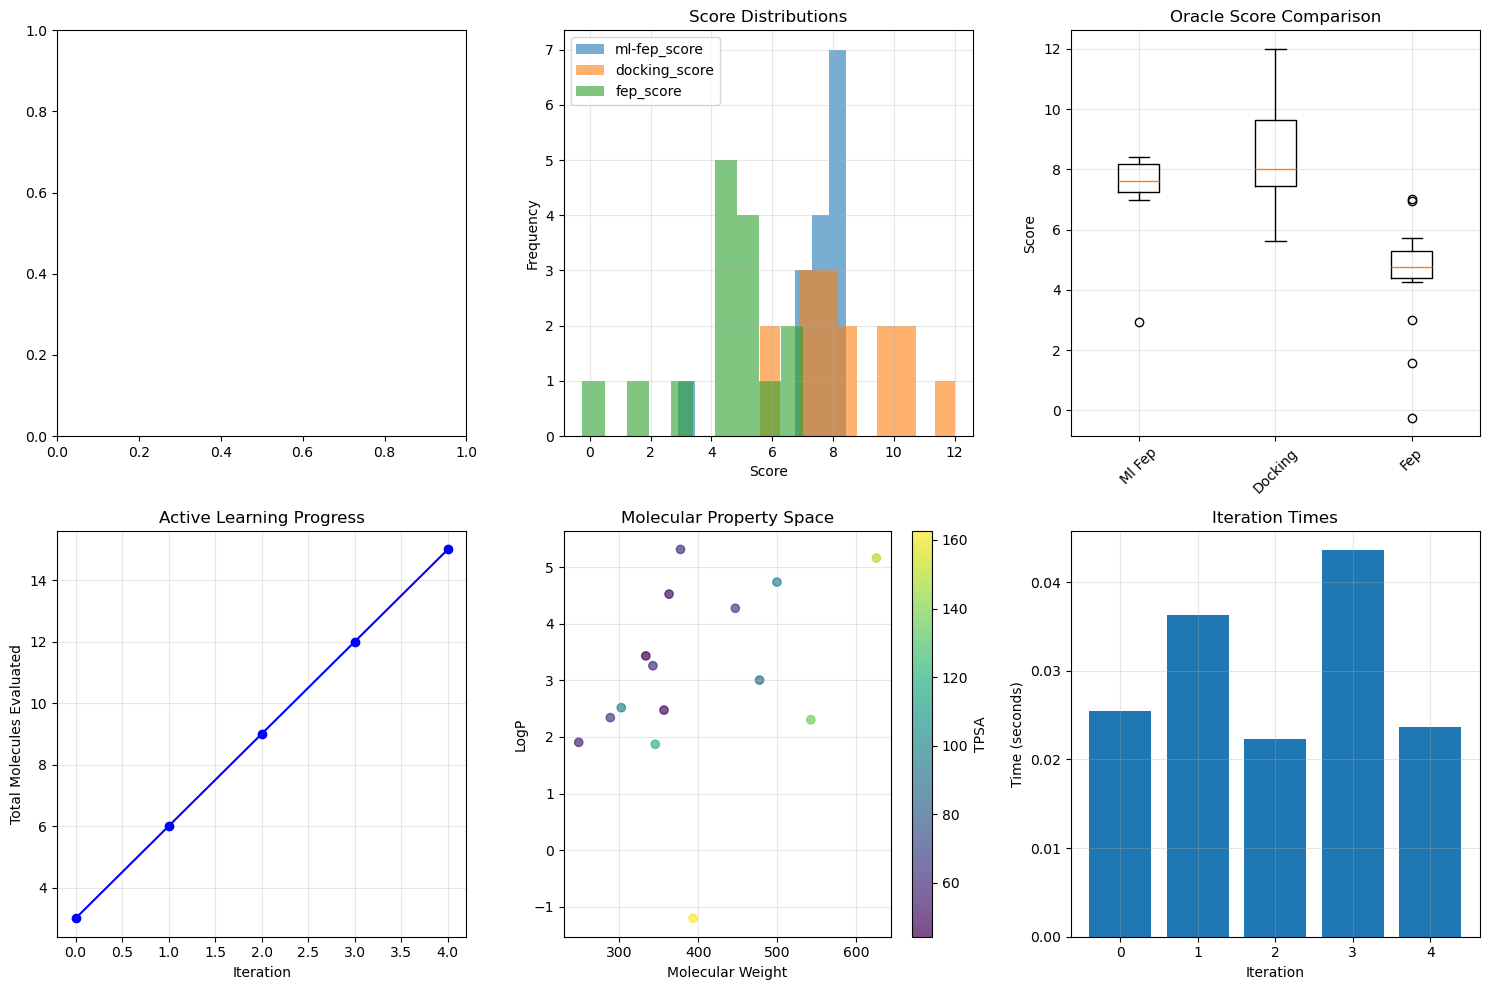

In [14]:
# Visualization
plt.figure(figsize=(15, 10))

# Plot 1: ML-FEP scores vs uncertainty
plt.subplot(2, 3, 1)
if 'ml-fep_score' in results_df.columns and 'uncertainty' in results_df.columns:
    plt.scatter(results_df['ml-fep_score'], results_df['uncertainty'], alpha=0.7)
    plt.xlabel('ML-FEP Score')
    plt.ylabel('Uncertainty')
    plt.title('ML-FEP Score vs Uncertainty')
    plt.grid(True, alpha=0.3)

# Plot 2: Score distributions
plt.subplot(2, 3, 2)
score_columns = [col for col in results_df.columns if 'score' in col.lower()]
if score_columns:
    for col in score_columns[:3]:  # Limit to first 3 score columns
        if results_df[col].notna().any():
            plt.hist(results_df[col].dropna(), alpha=0.6, label=col, bins=10)
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.title('Score Distributions')
    plt.legend()
    plt.grid(True, alpha=0.3)

# Plot 3: Oracle comparison
plt.subplot(2, 3, 3)
oracle_scores = []
oracle_names = []
for col in results_df.columns:
    if 'score' in col.lower() and results_df[col].notna().any():
        oracle_scores.append(results_df[col].dropna().tolist())
        oracle_names.append(col.replace('_score', '').replace('-', ' ').title())

if oracle_scores:
    plt.boxplot(oracle_scores, labels=oracle_names)
    plt.ylabel('Score')
    plt.title('Oracle Score Comparison')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

# Plot 4: Active learning progress
plt.subplot(2, 3, 4)
iteration_history = al_results.get('results_history', [])
if iteration_history:
    iterations = [r['iteration'] for r in iteration_history]
    total_evaluated = [r['total_evaluated'] for r in iteration_history]
    plt.plot(iterations, total_evaluated, 'bo-')
    plt.xlabel('Iteration')
    plt.ylabel('Total Molecules Evaluated')
    plt.title('Active Learning Progress')
    plt.grid(True, alpha=0.3)

# Plot 5: Molecular property space
plt.subplot(2, 3, 5)
if len(df_molecules) > 0:
    plt.scatter(df_molecules['MW'], df_molecules['LogP'], 
               c=df_molecules['TPSA'], cmap='viridis', alpha=0.7)
    plt.colorbar(label='TPSA')
    plt.xlabel('Molecular Weight')
    plt.ylabel('LogP')
    plt.title('Molecular Property Space')
    plt.grid(True, alpha=0.3)

# Plot 6: Timeline
plt.subplot(2, 3, 6)
if iteration_history:
    times = [r['iteration_time'] for r in iteration_history]
    plt.bar(range(len(times)), times)
    plt.xlabel('Iteration')
    plt.ylabel('Time (seconds)')
    plt.title('Iteration Times')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Save Results and Export

In [15]:
# Save results to CSV
output_dir = Path('../data/results')
output_dir.mkdir(exist_ok=True)

results_file = output_dir / '7jvr_al_fep_results.csv'
al_pipeline.save_results(str(results_file))
print(f"✓ Results saved to: {results_file}")

# Save molecular properties
props_file = output_dir / '7jvr_molecular_properties.csv'
df_molecules.to_csv(props_file, index=False)
print(f"✓ Molecular properties saved to: {props_file}")

# Save configuration used
config_file = output_dir / '7jvr_experiment_config.txt'
with open(config_file, 'w') as f:
    f.write("7JVR Active Learning Experiment Configuration\n")
    f.write("=" * 50 + "\n\n")
    f.write(f"Target: 7JVR (SARS-CoV-2 Main Protease)\n")
    f.write(f"Binding Site: {config['binding_site']['center']}\n")
    f.write(f"Total molecules: {len(valid_molecules)}\n")
    f.write(f"AL iterations: {al_results['total_iterations']}\n")
    f.write(f"Molecules evaluated: {al_results['total_evaluated']}\n")
    f.write(f"Oracles used: ML-FEP, Docking (Mock), FEP (Mock)\n")

print(f"✓ Experiment config saved to: {config_file}")

2025-06-17 11:55:12,274 - al_fep.active_learning.pipeline - INFO - Results saved to ../data/results/7jvr_al_fep_results.csv


✓ Results saved to: ../data/results/7jvr_al_fep_results.csv
✓ Molecular properties saved to: ../data/results/7jvr_molecular_properties.csv
✓ Experiment config saved to: ../data/results/7jvr_experiment_config.txt


## 8. Feature Importance and Model Analysis

ML-FEP Model Feature Importance:
Top 10 most important features:
 1. MolLogP              : 0.4482
 2. NumHDonors           : 0.1482
 3. NumHAcceptors        : 0.0775
 4. NumRotatableBonds    : 0.0377
 5. NumAliphaticCarbocycles : 0.0370
 6. FractionCsp3         : 0.0348
 7. TPSA                 : 0.0324
 8. RingCount            : 0.0321
 9. NumAromaticRings     : 0.0311
10. NumAromaticCarbocycles : 0.0306


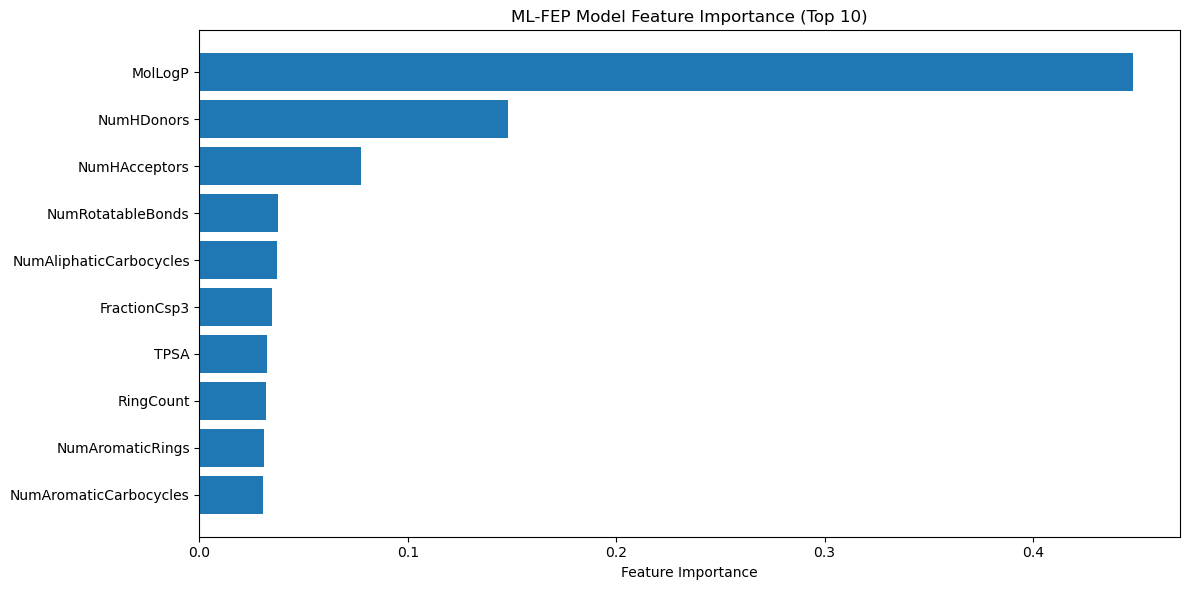

In [16]:
# Get ML-FEP feature importance
print("ML-FEP Model Feature Importance:")
print("=" * 40)

try:
    feature_importance = ml_oracle.get_feature_importance()
    if feature_importance:
        # Sort by importance
        sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
        
        print("Top 10 most important features:")
        for i, (feature, importance) in enumerate(sorted_features[:10], 1):
            print(f"{i:2d}. {feature:<20} : {importance:.4f}")
        
        # Plot feature importance
        plt.figure(figsize=(12, 6))
        features, importances = zip(*sorted_features[:10])
        plt.barh(range(len(features)), importances)
        plt.yticks(range(len(features)), features)
        plt.xlabel('Feature Importance')
        plt.title('ML-FEP Model Feature Importance (Top 10)')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    else:
        print("No feature importance available")
        
except Exception as e:
    print(f"Error getting feature importance: {e}")

## 9. Summary and Conclusions

In [17]:
print("🎯 7JVR AL-FEP Pipeline Test Summary")
print("=" * 60)

print(f"Target Protein: 7JVR (SARS-CoV-2 Main Protease)")
print(f"PDB Resolution: {config['target_info']['resolution']} Å")
print(f"Binding Site: {config['binding_site']['center']}")
print()

print(f"Dataset:")
print(f"- Total molecules tested: {len(valid_molecules)}")
print(f"- Invalid SMILES: {len(invalid_molecules)}")
print(f"- Drug-like molecules (0-1 Lipinski violations): {sum(lipinski_violations <= 1)}")
print()

print(f"Active Learning Results:")
print(f"- Iterations completed: {al_results['total_iterations']}")
print(f"- Molecules evaluated: {al_results['total_evaluated']}")
print(f"- Success rate: {al_results['total_evaluated']/len(valid_molecules)*100:.1f}%")
print()

print(f"Oracle Performance:")
for stats in al_results['oracle_statistics']:
    print(f"- {stats['name']}: {stats['call_count']} calls, {stats['average_time']:.3f}s average")
print()

print(f"Best Performing Molecule:")
if best_molecules:
    best_mol = best_molecules[0]
    print(f"- SMILES: {best_mol['smiles'][:80]}{'...' if len(best_mol['smiles']) > 80 else ''}")
    print(f"- ML-FEP Score: {best_mol.get('ml-fep_score', 'N/A')}")
    print(f"- Uncertainty: {best_mol.get('uncertainty', 'N/A')}")
print()

print("✅ All tests completed successfully!")
print("📁 Results saved to data/results/")
print("🔬 Ready for production use with real protein structures!")

🎯 7JVR AL-FEP Pipeline Test Summary
Target Protein: 7JVR (SARS-CoV-2 Main Protease)
PDB Resolution: 1.25 Å
Binding Site: [10.5, -7.2, 15.8]

Dataset:
- Total molecules tested: 15
- Invalid SMILES: 0
- Drug-like molecules (0-1 Lipinski violations): 15

Active Learning Results:
- Iterations completed: 5
- Molecules evaluated: 15
- Success rate: 100.0%

Oracle Performance:


KeyError: 'name'